# การทำนายโรคหลอดเลือดสมอง

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

In [4]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### id : รหัสผู้ป่วยที่ไม่ซ้ำกัน
#### gender : เพศ
#### age : อายุของผู้ป่วย
#### hypertension : 0=หากผู้ป่วยไม่มีความดันโลหิตสูง 1=หากผู้ป่วยมีความดันโลหิตสูง
#### heart_disease : 0=หากผู้ป่วยไม่มีโรคหัวใจ 1=หากผู้ป่วยเป็นโรคหัวใจ
#### ever_married : สถานะสมรส
#### work_type : อาชีพ
#### Residence_type : "ชนบท" หรือ "ในเมือง"
#### avg_glucose_level : ระดับน้ำตาลในเลือดเฉลี่ย
#### bmi : ดัชนีมวลกาย
#### smoking_status : สถานะการสูบบุหรี่
#### stroke : 1=ถ้าผู้ป่วยเป็นโรคหลอดเลือดสมองหรือ 0=ถ้าไม่เป็น

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**ตรวจสอบข้อมูลเบื้องต้น**

In [6]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

**bmi มีค่าว่าง 201 ค่า**

In [7]:
plt.style.use('ggplot')

<AxesSubplot:xlabel='bmi', ylabel='Density'>

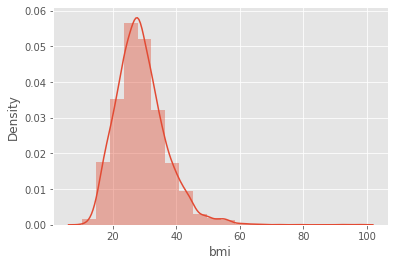

In [8]:
sns.distplot(df['bmi'] , bins=20)

In [9]:
df[df['gender'] == 'Male']['bmi'].mean()

28.647936350074616

In [10]:
df['bmi'] = df['bmi'].fillna(df[df['gender'] == 'Male']['bmi'].mean())

**แทนค่า bmi ที่ว่างด้วยค่าเฉลี่ย**

In [11]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.883588,7.698166,10.30,23.800,28.400,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


**อธิบายข้อมูลที่เป็นตัวเลข**

<AxesSubplot:xlabel='stroke', ylabel='count'>

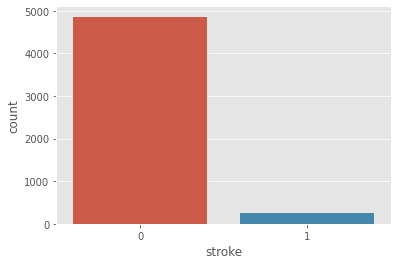

In [13]:
sns.countplot(data=df , x='stroke')

**สัดส่วนผู้ป่วยที่ไม่เป็นโรคหลอดเลือดสมอง และผู้ป่วยที่เป็นโรคหลอดเลือดสมอง**

<AxesSubplot:xlabel='gender', ylabel='count'>

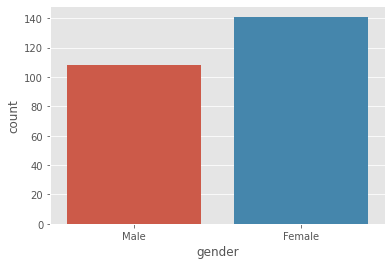

In [14]:
sns.countplot(data=df[df['stroke'] == 1 ] , x='gender')

**จำนวนผู้ป่วย แบ่งตามเพศ**

<AxesSubplot:xlabel='age', ylabel='Density'>

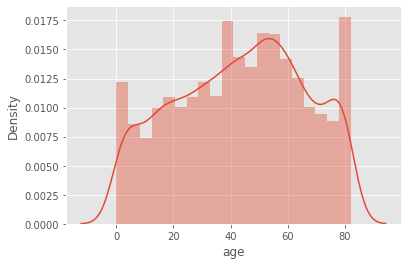

In [15]:
sns.distplot(df['age'] , bins=20)

**ช่วงอายุของผู้ป่วย**

<AxesSubplot:xlabel='age', ylabel='Density'>

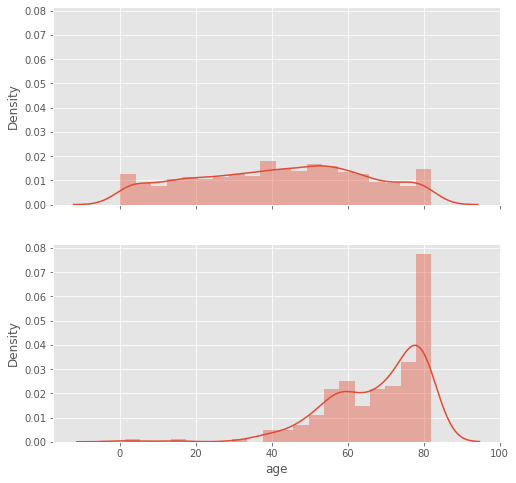

In [16]:
fig , ax = plt.subplots(2,1 , sharex=True ,sharey=True, figsize=(8,8))
sns.distplot(df[df['stroke'] == 0]['age'] , ax=ax[0] , bins=20)
sns.distplot(df[df['stroke'] == 1]['age'] , ax=ax[1] , bins=20)

**ช่วงอายุของผู้ป่วยที่ไม่เป็นโรคหลอกเลือดสมอง เทียบกับ ช่วงอายุของผู้ป่วยที่เป็นโรคหลอกเลือดสมอง**

**เห็นได้ชัดเจนว่าผู้ช่วยที่เป็นโรคหลอดเลือดสมองมักพบเจอในผู้ป่วยที่มีอายุมาก**

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Density'>

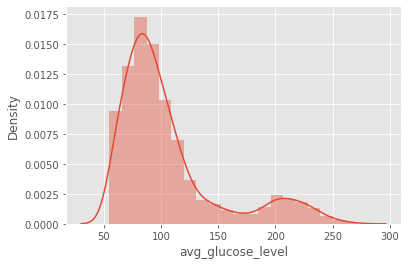

In [17]:
sns.distplot(df['avg_glucose_level'] , bins=20)

**ช่วงระดับน้ำตาลในเลือดของผู้ป่วย**

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Density'>

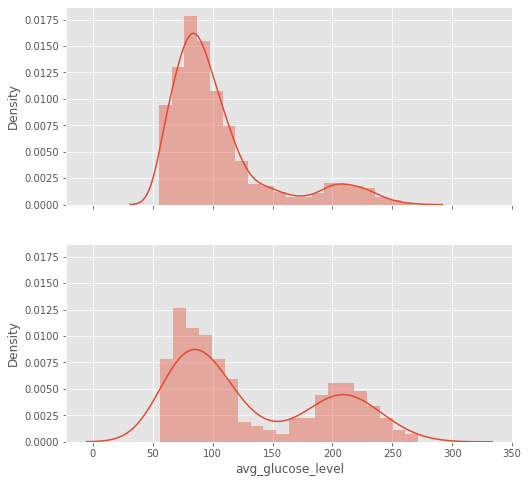

In [18]:
fig , ax = plt.subplots(2,1 , sharex=True ,sharey=True, figsize=(8,8))
sns.distplot(df[df['stroke'] == 0]['avg_glucose_level'] , ax=ax[0] , bins=20)
sns.distplot(df[df['stroke'] == 1]['avg_glucose_level'] , ax=ax[1] , bins=20)

**ช่วงระดับน้ำตาลในเลือดของผู้ป่วยที่ไม่เป็นโรคหลอดเลือด เทียบกับ ผู้ป่วยที่เป็นโรคหลอดเลือด**

**ระดับน้ำตาลของผู้ป่วยโรคหลอดเลือกสมองมีค่ามากกว่าเล็กน้อย**

<AxesSubplot:xlabel='bmi', ylabel='Density'>

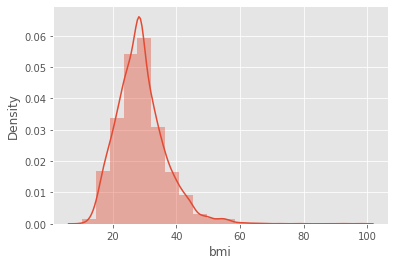

In [19]:
sns.distplot(df['bmi'] , bins=20)

**ช่วงของค่าดัชนีมวลกาย**

<AxesSubplot:xlabel='bmi', ylabel='Density'>

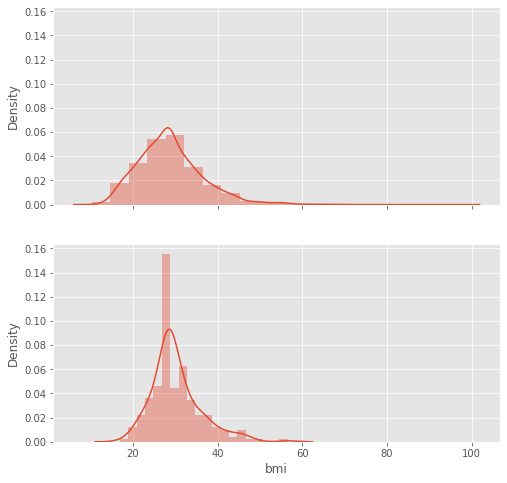

In [20]:
fig , ax = plt.subplots(2,1 , sharex=True ,sharey=True, figsize=(8,8))
sns.distplot(df[df['stroke'] == 0]['bmi'] , ax=ax[0] , bins=20)
sns.distplot(df[df['stroke'] == 1]['bmi'] , ax=ax[1] , bins=20)

**ช่วงของค่าดัชนีมวลกายของผู้ป่วยที่ ไม่เป็นโรคหลอดเลือด เทียบกับ ผู้ป่วยที่เป็นโรคหลอดเลือด มีค่าใกล้เคียงกัน**


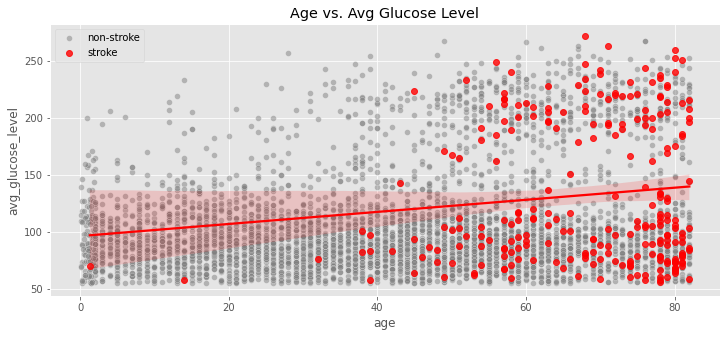

In [21]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=df[df['stroke'] == 0] , x='age' , y='avg_glucose_level' , color='0.5' , alpha=0.5 , label='non-stroke')
sns.regplot(data=df[df['stroke'] == 1] , x='age' , y='avg_glucose_level' , color='red' , label='stroke')
plt.title('Age vs. Avg Glucose Level')
plt.legend(loc='upper left')

**ความสัมพันธ์ของอายุกับระดับน้ำตาลในเลือด ของผู้ป่วยที่ไม่เป็นโรคหลอดเลือดสมองและเป็นโรคหลอดเลือดสมอง**

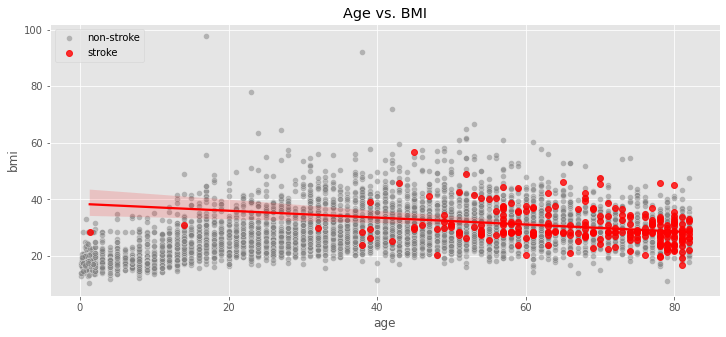

In [22]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=df[df['stroke'] == 0] , x='age' , y='bmi' , color='0.5' , alpha=0.5, label='non-stroke')
sns.regplot(data=df[df['stroke'] == 1] , x='age' , y='bmi' , color='red', label='stroke')
plt.title('Age vs. BMI')
plt.legend(loc='upper left')

**ความสัมพันธ์ของอายุกับค่าดัชนีมวลกาย ของผู้ป่วยที่ไม่เป็นโรคหลอดเลือดสมองและเป็นโรคหลอดเลือดสมอง**

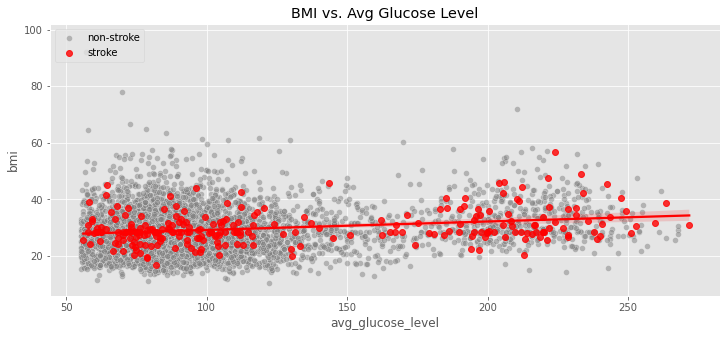

In [23]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=df[df['stroke'] == 0] , x='avg_glucose_level' , y='bmi' , color='0.5' , alpha=0.5, label='non-stroke')
sns.regplot(data=df[df['stroke'] == 1] , x='avg_glucose_level' , y='bmi' , color='red', label='stroke')
plt.title('BMI vs. Avg Glucose Level')
plt.legend(loc='upper left')

**ความสัมพันธ์ของระดับน้ำตาลในเลือดกับค่าดัชนีมวลกาย ของผู้ป่วยที่ไม่เป็นโรคหลอดเลือดสมองและเป็นโรคหลอดเลือดสมอง**

<AxesSubplot:xlabel='hypertension', ylabel='count'>

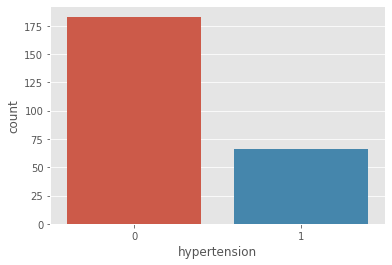

In [24]:
sns.countplot(data=df[df['stroke'] == 1] , x='hypertension')

**สถานะความดันโลหิต (0=ปกติ , 1=สูง) ของผู้ป่วยที่เป็นโรคหลอดเลือดในสมอง**

<AxesSubplot:xlabel='heart_disease', ylabel='count'>

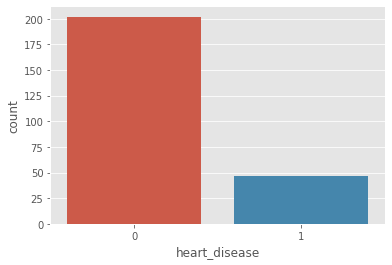

In [25]:
sns.countplot(data=df[df['stroke'] == 1] , x='heart_disease')

**สถานะโรคหัวใจ (0=เป็น , 1=ไม่เป็น) ของผู้ป่วยที่เป็นโรคหลอดเลือดในสมอง**

<AxesSubplot:xlabel='ever_married', ylabel='count'>

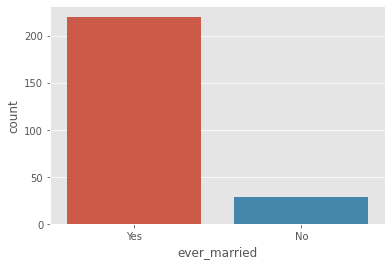

In [26]:
sns.countplot(df[df['stroke'] == 1]['ever_married'])

**สถานะสมรส (0=โสด , 1=สมรสแล้ว) ของผู้ป่วยที่เป็นโรคหลอดเลือดในสมอง**

<AxesSubplot:xlabel='work_type', ylabel='count'>

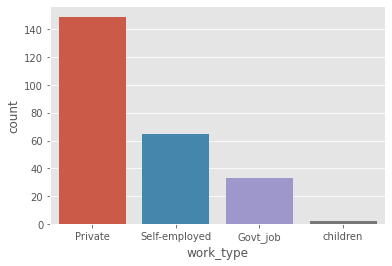

In [27]:
sns.countplot(df[df['stroke'] == 1]['work_type'])

**การประกอบอาชีพของผู้ป่วยที่เป็นโรคหลอดเลือดในสมอง**

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

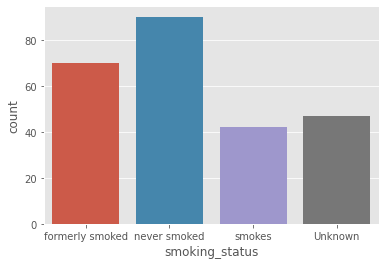

In [28]:
sns.countplot(df[df['stroke'] == 1]['smoking_status'])

**สถานะการสูบบุหรี่ของผู้ป่วยที่เป็นโรคหลอดเลือดในสมอง**

<AxesSubplot:xlabel='Residence_type', ylabel='count'>

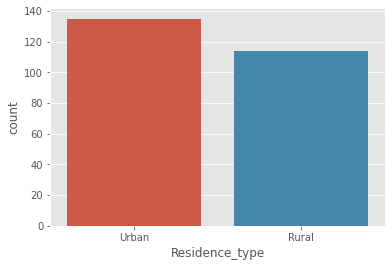

In [29]:
sns.countplot(df[df['stroke'] == 1]['Residence_type'])

**สถานที่อยู่ของผู้ป่วยที่เป็นโรคหลอดเลือดในสมอง**

<AxesSubplot:>

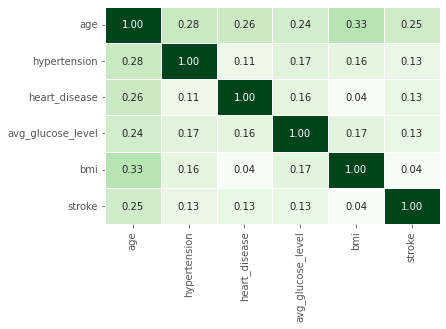

In [30]:
sns.heatmap(df.drop('id',axis=1).corr() , annot=True , fmt='0.2f' , cmap='Greens',cbar=False , linewidths=1)

**ความสัมพันธ์ของแต่ละคุณสมบัติ**

In [31]:
df_dum = df.copy()

In [32]:
for i in df_dum.columns :
    if df_dum[i].dtype == 'object' :
        df_dum = pd.concat([df_dum , df_dum[i].str.get_dummies().add_prefix(f'{i}_')] , axis=1)
        df_dum = df_dum.drop(i , axis=1)

In [33]:
df_dum.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.600000,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,0,0,202.21,28.647936,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.500000,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.400000,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.000000,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [34]:
features = df_dum.drop(['id' , 'stroke'] , axis=1)
target = df_dum['stroke']

In [35]:
x_train , x_val , y_train , y_val = train_test_split(features , target , test_size=0.3 , random_state=50 , stratify=target)
x_val , x_test , y_val , y_test = train_test_split(x_val , y_val , test_size=0.5 , random_state=50 , stratify=y_val)

<AxesSubplot:xlabel='stroke', ylabel='count'>

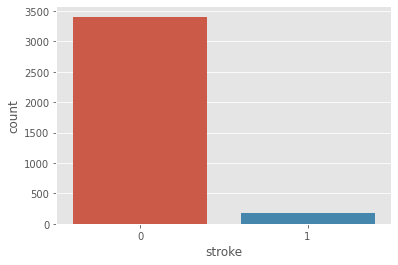

In [36]:
sns.countplot(y_train)

**ข้อมูลเป็นแบบ imbalanced ต้องปรับข้อมูลให้เท่ากัน**

In [37]:
smote = SMOTE()

In [38]:
x_train , y_train = smote.fit_resample(x_train , y_train)

<AxesSubplot:xlabel='stroke', ylabel='count'>

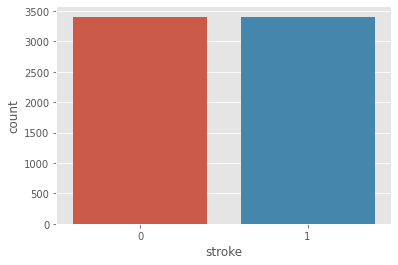

In [39]:
sns.countplot(y_train)

**ได้ข้อมูลที่เท่ากันแล้ว**

In [40]:
print('train data =',x_train.shape)
print('validation data =',x_val.shape)
print('test data =',x_test.shape)

train data = (6806, 21)
validation data = (766, 21)
test data = (767, 21)


**แบ่งข้อมูลเป็น 3 ส่วน**

In [41]:
lis_model = [LogisticRegression() , KNeighborsClassifier() , GaussianNB() , RandomForestClassifier() ,GradientBoostingClassifier()]

In [42]:
def modeling(model) :
    pipe = Pipeline([
        ('scale' , StandardScaler()) , 
        ('model' , model)
    ])
    pipe.fit(x_train , y_train)
    prediction = pipe.predict(x_val)
    
    print(str(model).replace('()',''))
    print('\n',classification_report(y_val , prediction)) 
    print('Accuracy Score =',accuracy_score(y_val , prediction).round(4))
    print('F1 Score =',f1_score(y_val , prediction).round(4))
    print('\n',confusion_matrix(y_val , prediction))
    print('-'*100)

**นำโมเดลมาทดสอบเบื้องต้น เพื่อหาโมเดลที่เหมาะสม**

In [43]:
for i in lis_model :
    modeling(i)

LogisticRegression

               precision    recall  f1-score   support

           0       0.95      1.00      0.98       729
           1       0.00      0.00      0.00        37

    accuracy                           0.95       766
   macro avg       0.48      0.50      0.49       766
weighted avg       0.91      0.95      0.93       766

Accuracy Score = 0.9517
F1 Score = 0.0

 [[729   0]
 [ 37   0]]
----------------------------------------------------------------------------------------------------
KNeighborsClassifier

               precision    recall  f1-score   support

           0       0.96      0.99      0.97       729
           1       0.31      0.11      0.16        37

    accuracy                           0.95       766
   macro avg       0.63      0.55      0.57       766
weighted avg       0.92      0.95      0.93       766

Accuracy Score = 0.9452
F1 Score = 0.16

 [[720   9]
 [ 33   4]]
------------------------------------------------------------------------

**จากการทดสอบเบื้องต้น KNeighborsClassifier ให้ผลลัพธ์ดีที่สุด**

In [44]:
knn = KNeighborsClassifier()

In [45]:
pipe_knn = Pipeline([
    ('scale' , StandardScaler()) ,
    ('model' , knn)
])

In [46]:
grid_knn = RandomizedSearchCV(pipe_knn , dict(model__n_neighbors=np.arange(5,15) , model__weights = ['uniform', 'distance']),
                              cv=5 , verbose=2 , n_jobs=-1)

In [47]:
grid_knn.fit(x_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'model__weights': ['uniform',
                                                           'distance']},
                   verbose=2)

**นำ KNeighborsClassifier มาปรับ parameter เพื่อหาค่าที่เหมาะสม**

In [48]:
grid_knn.fit(x_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.1s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'model__weights': ['uniform',
                                                           'distance']},
                   verbose=2)

In [49]:
print('train score =',grid_knn.score(x_train , y_train))
print('val score =',grid_knn.score(x_val , y_val))

train score = 1.0
val score = 0.9412532637075718


In [50]:
grid_knn.best_score_

0.9665133501862779

In [51]:
grid_knn.best_params_

{'model__weights': 'distance', 'model__n_neighbors': 9}

**ได้ parameter ที่เหมาะสมแล้ว ขั้นตอนสุดท้าย วัดประสิทธิภาพโมเดล**

In [52]:
model = grid_knn.best_estimator_

In [53]:
prediction = model.predict(x_test)

In [54]:
print(classification_report(prediction , y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       748
           1       0.08      0.16      0.11        19

    accuracy                           0.93       767
   macro avg       0.53      0.56      0.54       767
weighted avg       0.96      0.93      0.94       767



In [55]:
print('Accuracy Score =',accuracy_score(prediction , y_test).round(4))
print('F1 Score =',f1_score(prediction , y_test).round(4))

Accuracy Score = 0.9335
F1 Score = 0.1053


In [56]:
conf = pd.DataFrame(confusion_matrix(prediction , y_test) , index=['non-stroke' , 'stroke'] , columns=['non-stroke' , 'stroke'])

Text(33.0, 0.5, 'Prediction')

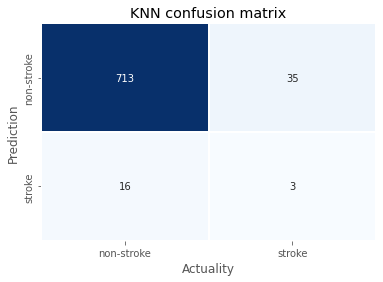

In [57]:
sns.heatmap(conf , annot=True , fmt='.0f' , cmap='Blues',cbar=False , linewidths=2)
plt.title('KNN confusion matrix')
plt.xlabel('Actuality')
plt.ylabel('Prediction')

In [58]:
prediction_proba = model.predict_proba(x_test)

In [59]:
tpr , fpr , ths = roc_curve(y_test , prediction_proba[:,1])

Text(0, 0.5, 'False Positive Rate')

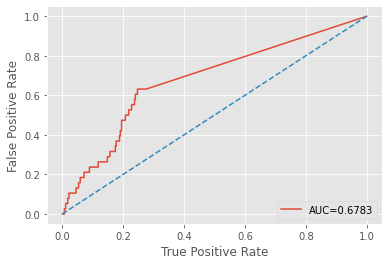

In [60]:
plt.plot(tpr , fpr , label=f'AUC={roc_auc_score(y_test , prediction_proba[:,1]).round(4)}')
plt.plot([0,1] , [0,1] , '--')
plt.legend(loc='lower right')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')